In [ ]:
import pandas as pd
data_path = pd.read_csv("/content/Book1.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


# loading the data set using a gdrive link from
#  google drive where i uploaded my csv file
url = 'https://drive.google.com/file/d/1fNeUMzbdbWZJvuSBypK3kGoQjYST9PKm/view?usp=sharing' 
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# Load data from csv file

# Load the data from CSV file and parses date and time columns to a single Datetime column 
# data = pd.read_csv(url, parse_dates={'datetime':['date', 'time']})
# sets date_time column as the index of the dataframe
# data = data.set_index('datetime')

# data = pd.read_csv(url) #,parse_dates=[['date', 'time']])

data = pd.read_csv(url, parse_dates=[['date', 'time']])
# sets date_time column as the index of the dataframe
data = data.set_index('date_time')

# Split the data into training and testing sets
# train_data = data[:int(0.8*len(data))]
# test_data = data[int(0.8*len(data)):]
train_data = data.loc['2021-12-01 00:00:00':'2022-11-30 23:45:00']
test_data = data.loc['2022-12-01 00:00:00':'2022-12-31 23:45:00']


# # Normalize the data
# scaler = MinMaxScaler()
# train_data = scaler.fit_transform(train_data[['temperature', 'humidity', 'power']])
# test_data = scaler.transform(test_data[['temperature', 'humidity', 'power']])

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['temperature', 'humidity', 'power']])
train_data = pd.DataFrame(train_data_scaled, columns=['temperature', 'humidity', 'power'], index=train_data.index)
test_data_scaled = scaler.transform(test_data[['temperature', 'humidity', 'power']])
test_data = pd.DataFrame(test_data_scaled, columns=['temperature', 'humidity', 'power'], index=test_data.index)
# Define sequence length for input data
seq_length = 30

# Function to create input/output sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        # X.append(data[['temperature', 'humidity']].iloc[i:i+seq_length])
        # y.append(data['power'].iloc[i+seq_length])

        # X_seq = data.iloc[[i:i+seq_length],['temperature', 'humidity']]
        # y_seq = data.iloc[[i+seq_length],['power']]
        # X.append(X_seq)
        # y.append(y_seq)

        X_seq = data.iloc[i:i+seq_length][['temperature', 'humidity']].to_numpy()
        y_seq = data.iloc[i+seq_length]['power']
        X.append(X_seq)
        y.append(y_seq)

    return np.array(X), np.array(y)

# Create the input and output sequences for training and testing
# X_train, y_train = create_sequences(train_data, seq_length)
# X_test, y_test = create_sequences(test_data, seq_length)

# Create the input and output sequences for training and testing
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict power consumption for test set
y_pred = model.predict(X_test)

<ipython-input-2-99a4c03c651a>:28: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_data = data.loc['2021-12-01 00:00:00':'2022-11-30 23:45:00']


Epoch 1/50
955/955 [==============================] - 20s 11ms/step - loss: 0.0123 - val_loss: 0.0077
Epoch 2/50
955/955 [==============================] - 8s 9ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 3/50
955/955 [==============================] - 9s 9ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 4/50
955/955 [==============================] - 9s 10ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 5/50
955/955 [==============================] - 9s 10ms/step - loss: 0.0087 - val_loss: 0.0065
Epoch 6/50
955/955 [==============================] - 8s 9ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 7/50
955/955 [==============================] - 9s 10ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 8/50
955/955 [==============================] - 10s 10ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 9/50
955/955 [==============================] - 9s 9ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 10/50
955/955 [==============================] - 8s 9ms/step - loss: 0.0074 - val_loss:

RMSE: 0.0282746127906599


<ipython-input-3-e6ba3e847a07>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


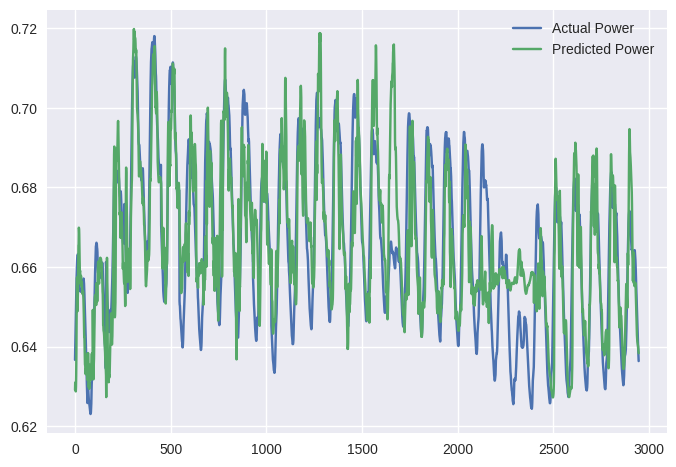

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
# Denormalize the predictions and targets
std = train_data['power'].std()
mean = train_data['power'].mean()

y_pred = (y_pred * std) + mean
y_test = (y_test * std) + mean

# Calculate RMSE for the predictions
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', rmse)

# Plot actual power and predicted power
plt.plot(y_test, label='Actual Power')
plt.plot(y_pred, label='Predicted Power')

# Calculate and plot the error between actual and predicted power
error = y_test - y_pred
# plt.plot(error, label='Error')
# plt.ylabel()
# plt.xlabel()
plt.legend()
plt.show()

In [ ]:
# Define the number of time steps to predict
num_steps = 15*24*15 # 15 days of 15-minute intervals

# Create input sequences for prediction
last_sequence = train_data.tail(seq_length).to_numpy()
prediction_input = np.expand_dims(last_sequence, axis=0)

# Make predictions
predictions = []
for i in range(num_steps):
    prediction = model.predict(prediction_input)[0][0]
    predictions.append(prediction)
    
    # Update the input sequence for the next prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = [test_data_scaled[i][0], test_data_scaled[i][1], prediction]
    prediction_input = np.expand_dims(last_sequence, axis=0)

# Scale back the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Define the time steps for the predictions
prediction_steps = pd.date_range(start=test_data.index[-1], periods=num_steps+1, freq='15T')[1:]

# Calculate the error for every 15 minutes and multiples of 15 minutes
step = 15
error = []
for i in range(0, len(predictions), step):
    error.append(rmse(predictions[i:i+step], test_data['power'][i:i+step].to_numpy()))

# Plot the error vs time step predicted
plt.plot(prediction_steps[::step], error)
plt.xlabel('Time step predicted (in 15 minute intervals)')
plt.ylabel('RMSE')

# Update the axis labels to show important time stamps
plt.xticks([prediction_steps[0], prediction_steps[95], prediction_steps[191], prediction_steps[287], 
            prediction_steps[403], prediction_steps[719], prediction_steps[1439], prediction_steps[-1]], 
           ['15m', '1 day', '2 days', '3 days', '4 days', '1 week', '2 weeks', '15 days'], rotation=45)

plt.show()


1/1 [==============================] - 0s 28ms/step


IndexError: ignored

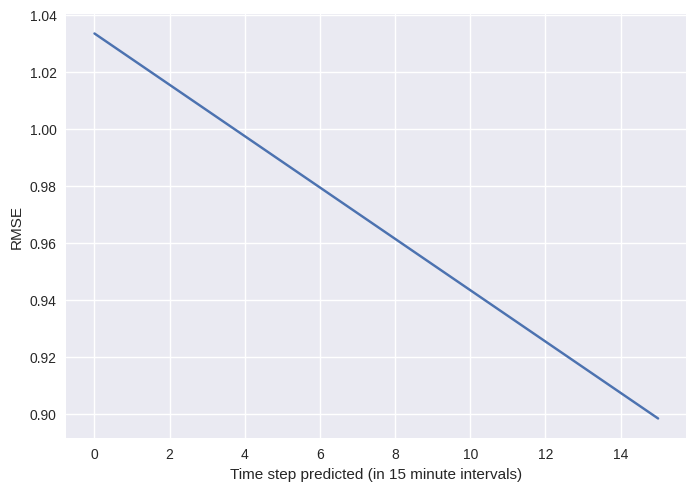

In [ ]:
# Define a function to calculate the root mean squared error (RMSE)
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the error for every 15 minutes and multiples of 15 minutes
step = 15
error = []
for i in range(0, len(y_test), step):
    error.append(rmse(y_pred[i:i+step], y_test[i:i+step]))

# Plot the error vs time step predicted
plt.plot(np.arange(0, len(y_test), step), error)
plt.xlabel('Time step predicted (in 15 minute intervals)')
plt.ylabel('RMSE')

# Update the axis labels to show important time stamps
# plt.xticks([ 1,96, 96*2, 96*3, 672,1344], ['15m','1 day','2d','3d', '1 week', '2 weeks'])

plt.show()
